In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd

# Define the path to your dataset
data_dir = 'ML dataset/Kitchen'

# List all classes
classes = ['Cup', 'Cutting_Boards', 'Kitchen_appliances', 'Pan', 'Plate', 'Pot', 'Utensil']

# Create a list to store images and labels
images = []
labels = []

# Load images and labels
for i, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        images.append(img_path)
        labels.append(str(i))  # Convert label to string

# Create a DataFrame from the lists
data = {'filepath': images, 'label': labels}
df = pd.DataFrame(data)

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Hyperparameters
input_shape = (224, 224, 3)
batch_size = 32
epochs = 35
learning_rate = 0.001

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)



Found 218 validated image filenames belonging to 7 classes.
Found 55 validated image filenames belonging to 7 classes.


In [2]:
# Model Architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 classes


In [3]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [5]:
# Callbacks
checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [6]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint]
)

Epoch 1/35


6/6 [==============================] - ETA: 0s - loss: 2.2860 - accuracy: 0.1989

C:\Users\Kusal\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 33s 6s/step - loss: 2.2860 - accuracy: 0.1989 - val_loss: 1.9077 - val_accuracy: 0.1875
Epoch 2/35
6/6 [==============================] - 28s 5s/step - loss: 1.7330 - accuracy: 0.2957 - val_loss: 1.5792 - val_accuracy: 0.4375
Epoch 3/35
6/6 [==============================] - 28s 5s/step - loss: 1.4857 - accuracy: 0.4086 - val_loss: 1.5240 - val_accuracy: 0.4062
Epoch 4/35
6/6 [==============================] - 29s 5s/step - loss: 1.3501 - accuracy: 0.4677 - val_loss: 1.2175 - val_accuracy: 0.5312
Epoch 5/35
6/6 [==============================] - 28s 5s/step - loss: 1.2784 - accuracy: 0.5000 - val_loss: 1.2278 - val_accuracy: 0.4688
Epoch 6/35
6/6 [==============================] - 28s 5s/step - loss: 1.1542 - accuracy: 0.5753 - val_loss: 1.3328 - val_accuracy: 0.4375
Epoch 7/35
6/6 [==============================] - 28s 5s/step - loss: 1.1921 - accuracy: 0.5645 - val_loss: 1.4605 - val_accuracy: 0.5000
Epoch 8/35
6/6 [=============================

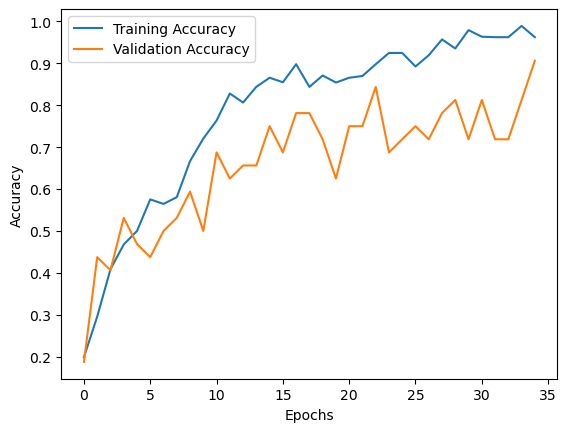

In [11]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
model.load_weights(checkpoint_path)
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {test_accuracy}")

2/2 [==============================] - 6s 2s/step - loss: 0.5769 - accuracy: 0.8545
Validation Accuracy: 0.8545454740524292


In [29]:
# Make Predictions
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

2/2 [==============================] - 6s 2s/step


In [36]:
# Display some predictions
class_labels = list(train_generator.class_indices.keys())
for i in range(10):
    print(f"Actual: {val_df.iloc[i]['filepath'].split('/')[-2]}, Predicted: {class_labels[predicted_classes[i]]}")

Actual: ML dataset, Predicted: 3
Actual: ML dataset, Predicted: 6
Actual: ML dataset, Predicted: 1
Actual: ML dataset, Predicted: 6
Actual: ML dataset, Predicted: 4
Actual: ML dataset, Predicted: 6
Actual: ML dataset, Predicted: 5
Actual: ML dataset, Predicted: 6
Actual: ML dataset, Predicted: 0
Actual: ML dataset, Predicted: 2


In [37]:
# Save the entire model to a HDF5 file
model.save("Kitchen_Items.h5")


In [40]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model("Kitchen_Items.h5")  # Replace with the path to your saved checkpoint

# Function to preprocess an image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0, 1]
    return img_array

# Example: Path to a new image you want to predict
new_image_path = "images (1).jpeg"

# Preprocess the image
new_image = preprocess_image(new_image_path)

# Make predictions
predictions = model.predict(new_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the class index to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

1/1 [==============================] - 0s 78ms/step
Predicted class: 6


In [33]:
# Assuming train_generator is your ImageDataGenerator for training
class_labels = train_generator.class_indices

# Display the available classes
print("Available Classes:")
for class_name, class_index in class_labels.items():
    print(f"Class Index {class_index}: {class_name}")


Available Classes:
Class Index 0: 0
Class Index 1: 1
Class Index 2: 2
Class Index 3: 3
Class Index 4: 4
Class Index 5: 5
Class Index 6: 6
